In [1]:
images_path = '/kaggle/input/reef-support/images'
mask_bleach_path = '/kaggle/input/reef-support/masks_bleached'
masks_non_bleach_path = '/kaggle/input/reef-support/masks_non_bleached'

In [2]:
import os
from PIL import Image
def analyze_dataset_structure():
    """Analyze basic dataset structure and size"""
    print("=== DATASET STRUCTURE AND SIZE ANALYSIS ===\n")
    
    # Get file lists
    image_files = os.listdir(images_path) if os.path.exists(images_path) else []
    bleach_mask_files = os.listdir(mask_bleach_path) if os.path.exists(mask_bleach_path) else []
    non_bleach_mask_files = os.listdir(masks_non_bleach_path) if os.path.exists(masks_non_bleach_path) else []
    
    # 1. How many images do you have?
    print("📊 FILE COUNTS:")
    print(f"   Total images: {len(image_files)}")
    print(f"   Bleached masks: {len(bleach_mask_files)}")
    print(f"   Non-bleached masks: {len(non_bleach_mask_files)}")
    print()
    
    
    # 2. Sample image dimensions
    print("📐 IMAGE DIMENSIONS (sampling first 5 images):")
    dimensions = []
    for i, img_file in enumerate(image_files[:5]):
        try:
            img_path = os.path.join(images_path, img_file)
            with Image.open(img_path) as img:
                width, height = img.size
                dimensions.append((width, height))
                print(f"   {img_file}: {width} x {height} pixels")
        except Exception as e:
            print(f"   Error reading {img_file}: {e}")
    
    if dimensions:
        unique_dims = list(set(dimensions))
        print(f"\n   Unique dimensions found: {unique_dims}")
        if len(unique_dims) == 1:
            print("   ✅ All sampled images have consistent dimensions")
        else:
            print("   ⚠️  Images have different dimensions")
    print()

# Run the analysis
analyze_dataset_structure()

=== DATASET STRUCTURE AND SIZE ANALYSIS ===

📊 FILE COUNTS:
   Total images: 658
   Bleached masks: 658
   Non-bleached masks: 658

📐 IMAGE DIMENSIONS (sampling first 5 images):
   C2_Gy_PP_T3_27nov24_CDaza_corr.jpg: 3393 x 2629 pixels
   C1_PB_PSb_T1_19nov24_HBenavides_Corr.JPG: 4216 x 3217 pixels
   C5_BC_PSa_T1_29nov24_CDaza_corr.jpg: 3269 x 2517 pixels
   C7_Gy_PM_T2_27nov24_CGomez_corr.jpg: 3369 x 2613 pixels
   C12_Gr_PM_T2_30nov24_CGomez_corr.jpg: 3233 x 2457 pixels

   Unique dimensions found: [(3369, 2613), (3393, 2629), (3233, 2457), (3269, 2517), (4216, 3217)]
   ⚠️  Images have different dimensions



In [3]:
def get_mask_filename(img_filename, mask_type='bleached'):
    """Convert image filename to corresponding mask filename"""
    base_name = os.path.splitext(img_filename)[0]
    if mask_type == 'bleached':
        return base_name + '_bleached.png'
    else:
        return base_name + '_non_bleached.png'

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2
def visualize_sample_images(num_samples=6, figsize=(20, 15)):
    """Visualize sample images with their masks"""
    print("\n=== VISUALIZING SAMPLE IMAGES ===")
    
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg')) or f.endswith('.JPG')]
    
    if len(image_files) == 0:
        print("No image files found!")
        return
    
    fig, axes = plt.subplots(num_samples, 4, figsize=figsize)
    fig.suptitle('Sample Coral Images with Masks', fontsize=16, fontweight='bold')
    
    # Column headers
    col_titles = ['Original Image', 'Bleached Mask', 'Non-Bleached Mask', 'Combined Masks']
    for i, title in enumerate(col_titles):
        axes[0, i].set_title(title, fontsize=12, fontweight='bold', pad=20)
    
    # Sample random images
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))
    
    for idx, img_file in enumerate(sample_files):
        try:
            # Load original image
            img_path = os.path.join(images_path, img_file)
            img = np.array(Image.open(img_path))
            
            # Load masks
            bleach_mask_file = get_mask_filename(img_file, 'bleached')
            non_bleach_mask_file = get_mask_filename(img_file, 'non_bleached')
            
            bleach_mask = np.array(Image.open(os.path.join(mask_bleach_path, bleach_mask_file)))
            non_bleach_mask = np.array(Image.open(os.path.join(masks_non_bleach_path, non_bleach_mask_file)))
            
            # Convert masks to binary if needed
            if len(bleach_mask.shape) == 3:
                bleach_mask = cv2.cvtColor(bleach_mask, cv2.COLOR_RGB2GRAY)
            if len(non_bleach_mask.shape) == 3:
                non_bleach_mask = cv2.cvtColor(non_bleach_mask, cv2.COLOR_RGB2GRAY)
            
            bleach_mask = (bleach_mask > 127).astype(np.uint8)
            non_bleach_mask = (non_bleach_mask > 127).astype(np.uint8)
            
            # Original image
            axes[idx, 0].imshow(img)
            axes[idx, 0].set_title(f'{img_file[:20]}...', fontsize=8)
            
            # Bleached mask only (red)
            axes[idx, 1].imshow(bleach_mask, cmap='Reds')
            
            # Non-bleached mask only (green)
            axes[idx, 2].imshow(non_bleach_mask, cmap='Greens')
            
            # Combined masks (red + green, no original image)
            combined_mask = np.zeros((bleach_mask.shape[0], bleach_mask.shape[1], 3), dtype=np.uint8)
            combined_mask[bleach_mask == 1] = [255, 0, 0]      # Red for bleached
            combined_mask[non_bleach_mask == 1] = [0, 255, 0]  # Green for healthy
            # Yellow for overlap (if any)
            combined_mask[(bleach_mask == 1) & (non_bleach_mask == 1)] = [255, 255, 0]
            
            axes[idx, 3].imshow(combined_mask)
            
            # Check for overlaps and display warning
            overlap = np.sum((bleach_mask == 1) & (non_bleach_mask == 1))
            if overlap > 0:
                axes[idx, 3].set_title(f'⚠️ Overlap: {overlap} px', fontsize=8, color='orange')
            
            # Remove axis ticks
            for j in range(4):
                axes[idx, j].set_xticks([])
                axes[idx, j].set_yticks([])
                
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
            # Fill with blank axes if error
            for j in range(4):
                axes[idx, j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return sample_files

visualize_sample_images(num_samples=6)


=== VISUALIZING SAMPLE IMAGES ===



=== CLASS DISTRIBUTION ANALYSIS (sampling 100 images) ===

📊 PIXEL DISTRIBUTION SUMMARY:
Average bleached ratio: 0.097 ± 0.120
Average healthy ratio: 0.223 ± 0.183
Average background ratio: 0.680 ± 0.219
Average coral coverage: 0.320 ± 0.219


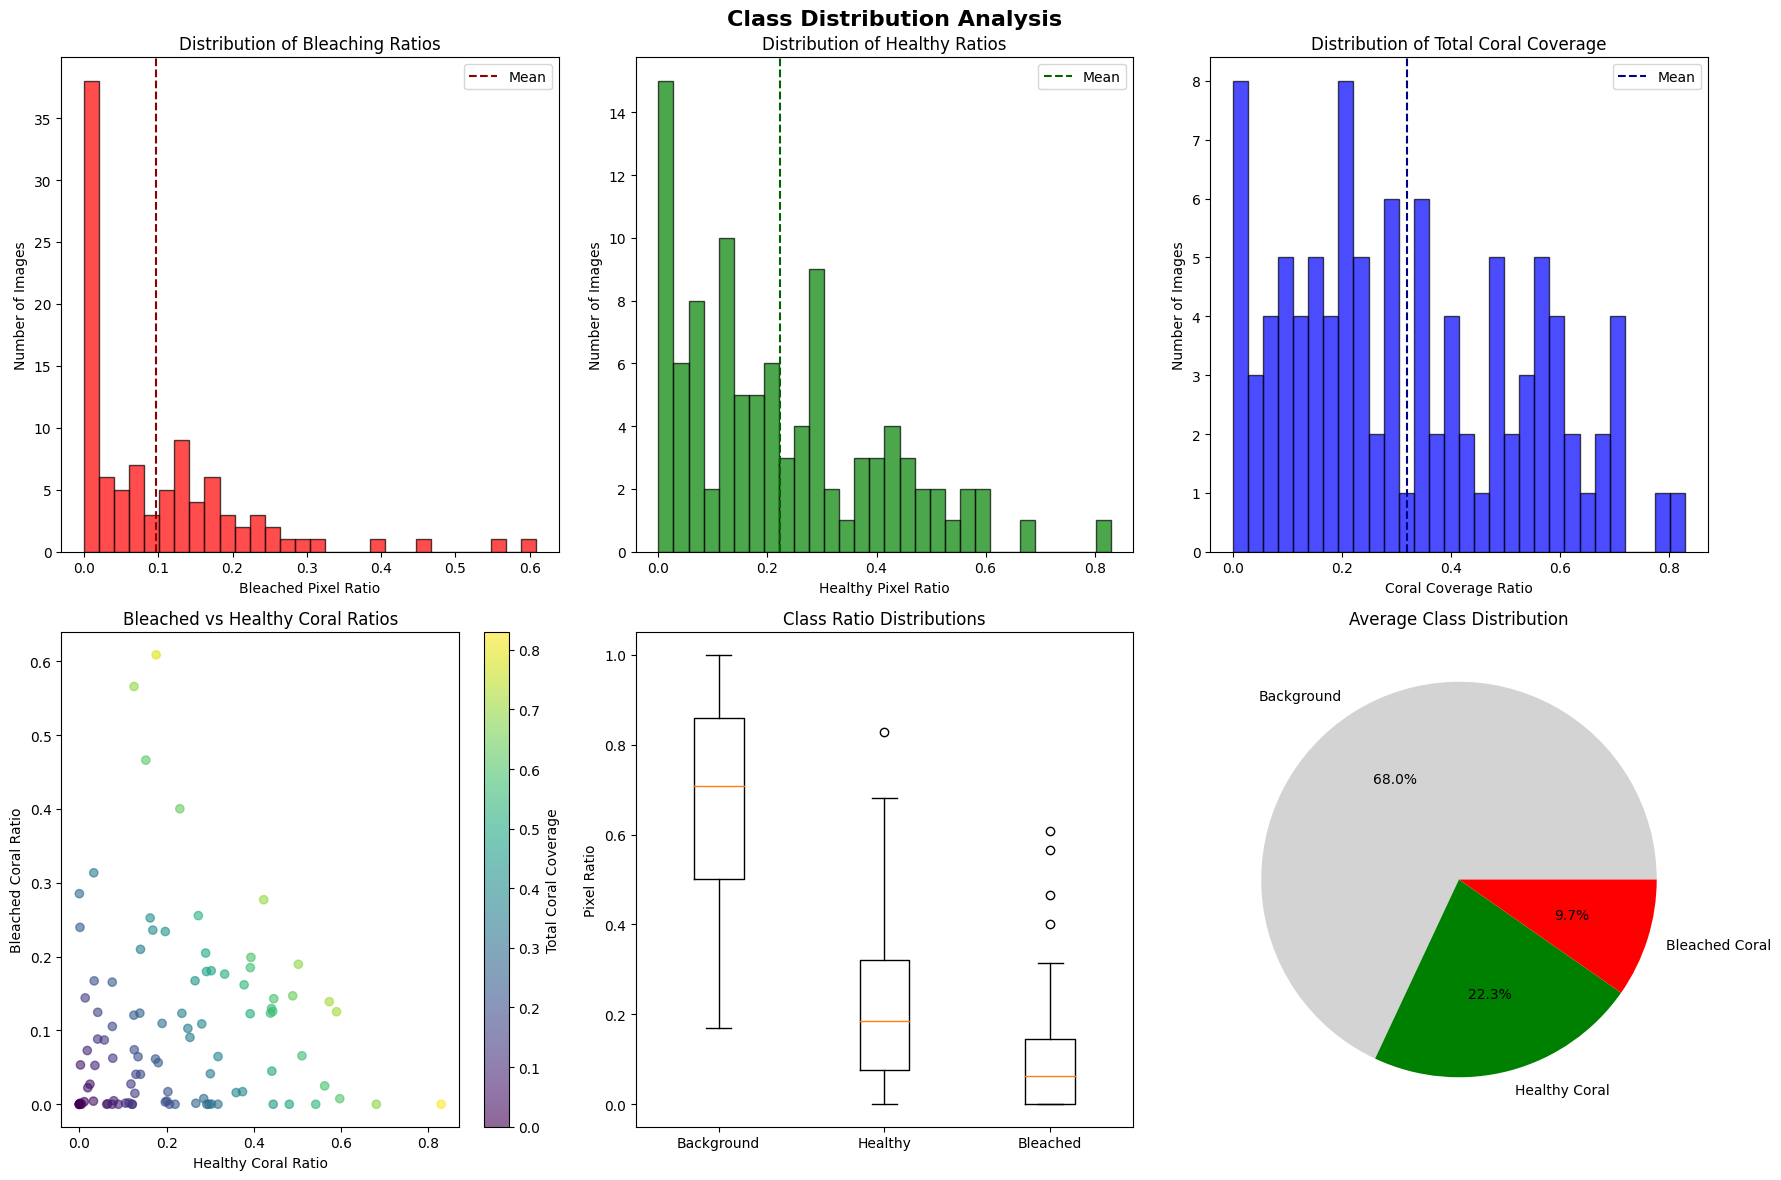

In [5]:
import pandas as pd
def plot_distribution_charts(df):
    """Plot various distribution charts"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Class Distribution Analysis', fontsize=16, fontweight='bold')
    
    # 1. Histogram of bleaching ratios
    axes[0, 0].hist(df['bleached_ratio'], bins=30, alpha=0.7, color='red', edgecolor='black')
    axes[0, 0].set_title('Distribution of Bleaching Ratios')
    axes[0, 0].set_xlabel('Bleached Pixel Ratio')
    axes[0, 0].set_ylabel('Number of Images')
    axes[0, 0].axvline(df['bleached_ratio'].mean(), color='darkred', linestyle='--', label='Mean')
    axes[0, 0].legend()
    
    # 2. Histogram of healthy ratios
    axes[0, 1].hist(df['healthy_ratio'], bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].set_title('Distribution of Healthy Ratios')
    axes[0, 1].set_xlabel('Healthy Pixel Ratio')
    axes[0, 1].set_ylabel('Number of Images')
    axes[0, 1].axvline(df['healthy_ratio'].mean(), color='darkgreen', linestyle='--', label='Mean')
    axes[0, 1].legend()
    
    # 3. Coral coverage histogram
    axes[0, 2].hist(df['coral_ratio'], bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 2].set_title('Distribution of Total Coral Coverage')
    axes[0, 2].set_xlabel('Coral Coverage Ratio')
    axes[0, 2].set_ylabel('Number of Images')
    axes[0, 2].axvline(df['coral_ratio'].mean(), color='darkblue', linestyle='--', label='Mean')
    axes[0, 2].legend()
    
    # 4. Scatter plot: Bleached vs Healthy
    scatter = axes[1, 0].scatter(df['healthy_ratio'], df['bleached_ratio'], 
                               c=df['coral_ratio'], cmap='viridis', alpha=0.6)
    axes[1, 0].set_title('Bleached vs Healthy Coral Ratios')
    axes[1, 0].set_xlabel('Healthy Coral Ratio')
    axes[1, 0].set_ylabel('Bleached Coral Ratio')
    plt.colorbar(scatter, ax=axes[1, 0], label='Total Coral Coverage')
    
    # 5. Box plot of class ratios
    data_to_plot = [df['background_ratio'], df['healthy_ratio'], df['bleached_ratio']]
    axes[1, 1].boxplot(data_to_plot, labels=['Background', 'Healthy', 'Bleached'])
    axes[1, 1].set_title('Class Ratio Distributions')
    axes[1, 1].set_ylabel('Pixel Ratio')
    
    # 6. Pie chart of average class distribution
    avg_ratios = [df['background_ratio'].mean(), 
                 df['healthy_ratio'].mean(), 
                 df['bleached_ratio'].mean()]
    labels = ['Background', 'Healthy Coral', 'Bleached Coral']
    colors = ['lightgray', 'green', 'red']
    
    axes[1, 2].pie(avg_ratios, labels=labels, colors=colors, autopct='%1.1f%%')
    axes[1, 2].set_title('Average Class Distribution')
    
    plt.tight_layout()
    plt.show()
    
def analyze_class_distribution(sample_size=100):
    """Analyze pixel distribution across classes"""
    print(f"\n=== CLASS DISTRIBUTION ANALYSIS (sampling {sample_size} images) ===")
    
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg')) or f.endswith('.JPG')]
    
    # Sample images for analysis
    sample_files = random.sample(image_files, min(sample_size, len(image_files)))
    
    stats = []
    
    for img_file in sample_files:
        try:
            # Load masks
            bleach_mask_file = get_mask_filename(img_file, 'bleached')
            non_bleach_mask_file = get_mask_filename(img_file, 'non_bleached')
            
            bleach_mask = np.array(Image.open(os.path.join(mask_bleach_path, bleach_mask_file)))
            non_bleach_mask = np.array(Image.open(os.path.join(masks_non_bleach_path, non_bleach_mask_file)))
            
            # Convert to binary
            if len(bleach_mask.shape) == 3:
                bleach_mask = cv2.cvtColor(bleach_mask, cv2.COLOR_RGB2GRAY)
            if len(non_bleach_mask.shape) == 3:
                non_bleach_mask = cv2.cvtColor(non_bleach_mask, cv2.COLOR_RGB2GRAY)
            
            bleach_mask = (bleach_mask > 127).astype(np.uint8)
            non_bleach_mask = (non_bleach_mask > 127).astype(np.uint8)
            
            total_pixels = bleach_mask.shape[0] * bleach_mask.shape[1]
            bleached_pixels = np.sum(bleach_mask)
            healthy_pixels = np.sum(non_bleach_mask)
            background_pixels = total_pixels - bleached_pixels - healthy_pixels
            
            # Check for overlap
            overlap_pixels = np.sum((bleach_mask == 1) & (non_bleach_mask == 1))
            
            stats.append({
                'filename': img_file,
                'total_pixels': total_pixels,
                'bleached_pixels': bleached_pixels,
                'healthy_pixels': healthy_pixels,
                'background_pixels': background_pixels,
                'overlap_pixels': overlap_pixels,
                'bleached_ratio': bleached_pixels / total_pixels,
                'healthy_ratio': healthy_pixels / total_pixels,
                'background_ratio': background_pixels / total_pixels,
                'coral_ratio': (bleached_pixels + healthy_pixels) / total_pixels
            })
            
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
    
    df = pd.DataFrame(stats)
    
    # Summary statistics
    print("\n📊 PIXEL DISTRIBUTION SUMMARY:")
    print(f"Average bleached ratio: {df['bleached_ratio'].mean():.3f} ± {df['bleached_ratio'].std():.3f}")
    print(f"Average healthy ratio: {df['healthy_ratio'].mean():.3f} ± {df['healthy_ratio'].std():.3f}")
    print(f"Average background ratio: {df['background_ratio'].mean():.3f} ± {df['background_ratio'].std():.3f}")
    print(f"Average coral coverage: {df['coral_ratio'].mean():.3f} ± {df['coral_ratio'].std():.3f}")
    
    if df['overlap_pixels'].sum() > 0:
        print(f"⚠️ Found overlapping pixels in {(df['overlap_pixels'] > 0).sum()} images")
    
    # Plot distributions
    plot_distribution_charts(df)
    
    return df
df=analyze_class_distribution(sample_size=100)

In [6]:
def check_class_imbalance(df):
    """Check for severe class imbalances"""
    print("\n=== CLASS IMBALANCE ANALYSIS ===")
    
    # Define thresholds for imbalance
    severe_bleaching_threshold = 0.8  # >80% bleached
    minimal_bleaching_threshold = 0.05  # <5% bleached
    minimal_coral_threshold = 0.1  # <10% coral coverage
    
    severe_bleaching = df[df['bleached_ratio'] > severe_bleaching_threshold]
    minimal_bleaching = df[df['bleached_ratio'] < minimal_bleaching_threshold]
    minimal_coral = df[df['coral_ratio'] < minimal_coral_threshold]
    
    print(f"Images with severe bleaching (>{severe_bleaching_threshold*100}% bleached): {len(severe_bleaching)}")
    print(f"Images with minimal bleaching (<{minimal_bleaching_threshold*100}% bleached): {len(minimal_bleaching)}")
    print(f"Images with minimal coral coverage (<{minimal_coral_threshold*100}% coral): {len(minimal_coral)}")
    
    # Show examples of extreme cases
    if len(severe_bleaching) > 0:
        print(f"\nExamples of severely bleached images:")
        for _, row in severe_bleaching.head(3).iterrows():
            print(f"  - {row['filename']}: {row['bleached_ratio']:.2%} bleached")
    
    if len(minimal_coral) > 0:
        print(f"\nExamples of images with minimal coral:")
        for _, row in minimal_coral.head(3).iterrows():
            print(f"  - {row['filename']}: {row['coral_ratio']:.2%} coral coverage")
    
    return {
        'severe_bleaching': severe_bleaching,
        'minimal_bleaching': minimal_bleaching,
        'minimal_coral': minimal_coral
    }
imbalance_results = check_class_imbalance(df)


=== CLASS IMBALANCE ANALYSIS ===
Images with severe bleaching (>80.0% bleached): 0
Images with minimal bleaching (<5.0% bleached): 46
Images with minimal coral coverage (<10.0% coral): 19

Examples of images with minimal coral:
  - C6_PB_PM_T3_19nov24_CGomez_Corr.JPG: 0.00% coral coverage
  - C7_PB_PM_T3_19nov24_CGomez_Corr.JPG: 0.04% coral coverage
  - C6_Gy_PSa_T1_27nov24_CDaza_corr.jpg: 3.64% coral coverage


In [7]:
def find_coral_bounding_box(bleach_mask, non_bleach_mask, padding_ratio=0.1):
    """
    Find bounding box around coral regions with smart padding
    
    Args:
        bleach_mask: Binary mask of bleached coral
        non_bleach_mask: Binary mask of healthy coral
        padding_ratio: Additional padding around coral (as ratio of box size)
    
    Returns:
        (min_row, max_row, min_col, max_col): Bounding box coordinates
    """
    # Combine both coral masks
    combined_coral = (bleach_mask > 0) | (non_bleach_mask > 0)
    
    # Find coral coordinates
    coral_coords = np.where(combined_coral)
    
    if len(coral_coords[0]) == 0:
        # No coral found - return full image bounds
        return 0, bleach_mask.shape[0], 0, bleach_mask.shape[1]
    
    # Get bounding box
    min_row, max_row = coral_coords[0].min(), coral_coords[0].max()
    min_col, max_col = coral_coords[1].min(), coral_coords[1].max()
    
    # Add padding
    box_height = max_row - min_row
    box_width = max_col - min_col
    
    pad_h = int(box_height * padding_ratio)
    pad_w = int(box_width * padding_ratio)
    
    # Apply padding while staying within image bounds
    min_row = max(0, min_row - pad_h)
    max_row = min(bleach_mask.shape[0], max_row + pad_h)
    min_col = max(0, min_col - pad_w)
    max_col = min(bleach_mask.shape[1], max_col + pad_w)
    
    return min_row, max_row, min_col, max_col

def make_square_crop(min_row, max_row, min_col, max_col, img_height, img_width):
    """
    Expand rectangular bounding box to square while centering on coral
    
    Args:
        min_row, max_row, min_col, max_col: Original bounding box
        img_height, img_width: Image dimensions
        
    Returns:
        (crop_top, crop_bottom, crop_left, crop_right): Square crop coordinates
    """
    box_height = max_row - min_row
    box_width = max_col - min_col
    
    # Make it square by using the larger dimension
    target_size = max(box_height, box_width)
    
    # Center the square on the coral bounding box
    center_row = (min_row + max_row) // 2
    center_col = (min_col + max_col) // 2
    
    # Calculate square boundaries
    half_size = target_size // 2
    
    crop_top = max(0, center_row - half_size)
    crop_bottom = min(img_height, center_row + half_size)
    crop_left = max(0, center_col - half_size)
    crop_right = min(img_width, center_col + half_size)
    
    # Adjust if we hit image boundaries
    if crop_bottom - crop_top < target_size:
        if crop_top == 0:
            crop_bottom = min(img_height, crop_top + target_size)
        else:
            crop_top = max(0, crop_bottom - target_size)
            
    if crop_right - crop_left < target_size:
        if crop_left == 0:
            crop_right = min(img_width, crop_left + target_size)
        else:
            crop_left = max(0, crop_right - target_size)
    
    return crop_top, crop_bottom, crop_left, crop_right

def coral_aware_resize_crop(image, bleach_mask, non_bleach_mask, target_size=512, padding_ratio=0.1):
    """
    Main function: Coral-aware cropping and resizing
    
    Args:
        image: Input image (numpy array)
        bleach_mask: Bleached coral mask
        non_bleach_mask: Healthy coral mask
        target_size: Final output size (square)
        padding_ratio: Extra padding around coral regions
        
    Returns:
        cropped_image, cropped_bleach_mask, cropped_non_bleach_mask
    """
    # 1. Find coral bounding box
    min_row, max_row, min_col, max_col = find_coral_bounding_box(
        bleach_mask, non_bleach_mask, padding_ratio)
    
    # 2. Make it square
    crop_top, crop_bottom, crop_left, crop_right = make_square_crop(
        min_row, max_row, min_col, max_col, image.shape[0], image.shape[1])
    
    # 3. Crop all images/masks
    cropped_image = image[crop_top:crop_bottom, crop_left:crop_right]
    cropped_bleach = bleach_mask[crop_top:crop_bottom, crop_left:crop_right]
    cropped_non_bleach = non_bleach_mask[crop_top:crop_bottom, crop_left:crop_right]
    
    # 4. Resize to target size
    if cropped_image.shape[0] != target_size or cropped_image.shape[1] != target_size:
        cropped_image = cv2.resize(cropped_image, (target_size, target_size))
        cropped_bleach = cv2.resize(cropped_bleach, (target_size, target_size), 
                                  interpolation=cv2.INTER_NEAREST)
        cropped_non_bleach = cv2.resize(cropped_non_bleach, (target_size, target_size), 
                                      interpolation=cv2.INTER_NEAREST)
    
    # 5. Ensure masks are binary after resizing
    cropped_bleach = (cropped_bleach > 127).astype(np.uint8)
    cropped_non_bleach = (cropped_non_bleach > 127).astype(np.uint8)
    
    return cropped_image, cropped_bleach, cropped_non_bleach

def process_single_image(img_filename, target_size=512, padding_ratio=0.1):
    """Process a single image and its masks"""
    try:
        # Load image and masks
        img_path = os.path.join(images_path, img_filename)
        image = np.array(Image.open(img_path))
        
        bleach_mask_file = get_mask_filename(img_filename, 'bleached')
        non_bleach_mask_file = get_mask_filename(img_filename, 'non_bleached')
        
        bleach_mask = np.array(Image.open(os.path.join(mask_bleach_path, bleach_mask_file)))
        non_bleach_mask = np.array(Image.open(os.path.join(masks_non_bleach_path, non_bleach_mask_file)))
        
        # Convert masks to grayscale if needed
        if len(bleach_mask.shape) == 3:
            bleach_mask = cv2.cvtColor(bleach_mask, cv2.COLOR_RGB2GRAY)
        if len(non_bleach_mask.shape) == 3:
            non_bleach_mask = cv2.cvtColor(non_bleach_mask, cv2.COLOR_RGB2GRAY)
        
        # Apply coral-aware cropping
        cropped_img, cropped_bleach, cropped_non_bleach = coral_aware_resize_crop(
            image, bleach_mask, non_bleach_mask, target_size, padding_ratio)
        
        return cropped_img, cropped_bleach, cropped_non_bleach
        
    except Exception as e:
        print(f"Error processing {img_filename}: {e}")
        return None, None, None

def visualize_cropping_comparison(img_filename, target_size=512, padding_ratio=0.1):
    """Visualize before/after cropping for a single image"""
    
    # Load original
    img_path = os.path.join(images_path, img_filename)
    original_img = np.array(Image.open(img_path))
    
    bleach_mask_file = get_mask_filename(img_filename, 'bleached')
    non_bleach_mask_file = get_mask_filename(img_filename, 'non_bleached')
    
    original_bleach = np.array(Image.open(os.path.join(mask_bleach_path, bleach_mask_file)))
    original_non_bleach = np.array(Image.open(os.path.join(masks_non_bleach_path, non_bleach_mask_file)))
    
    # Convert to grayscale if needed
    if len(original_bleach.shape) == 3:
        original_bleach = cv2.cvtColor(original_bleach, cv2.COLOR_RGB2GRAY)
    if len(original_non_bleach.shape) == 3:
        original_non_bleach = cv2.cvtColor(original_non_bleach, cv2.COLOR_RGB2GRAY)
    
    # Process with coral-aware cropping
    cropped_img, cropped_bleach, cropped_non_bleach = coral_aware_resize_crop(
        original_img, original_bleach, original_non_bleach, target_size, padding_ratio)
    
    # Create visualization
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(f'Coral-Aware Cropping: {img_filename}', fontsize=16, fontweight='bold')
    
    # Original row
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title(f'Original\n{original_img.shape[1]}×{original_img.shape[0]}')
    
    axes[0, 1].imshow(original_bleach, cmap='Reds')
    axes[0, 1].set_title('Original Bleached Mask')
    
    axes[0, 2].imshow(original_non_bleach, cmap='Greens')
    axes[0, 2].set_title('Original Healthy Mask')
    
    # Combined original masks
    original_combined = np.zeros((*original_bleach.shape, 3), dtype=np.uint8)
    original_combined[original_bleach > 127] = [255, 0, 0]
    original_combined[original_non_bleach > 127] = [0, 255, 0]
    axes[0, 3].imshow(original_combined)
    axes[0, 3].set_title('Combined Original')
    
    # Cropped row
    axes[1, 0].imshow(cropped_img)
    axes[1, 0].set_title(f'Cropped & Resized\n{target_size}×{target_size}')
    
    axes[1, 1].imshow(cropped_bleach, cmap='Reds')
    axes[1, 1].set_title('Cropped Bleached Mask')
    
    axes[1, 2].imshow(cropped_non_bleach, cmap='Greens')
    axes[1, 2].set_title('Cropped Healthy Mask')
    
    # Combined cropped masks
    cropped_combined = np.zeros((*cropped_bleach.shape, 3), dtype=np.uint8)
    cropped_combined[cropped_bleach == 1] = [255, 0, 0]
    cropped_combined[cropped_non_bleach == 1] = [0, 255, 0]
    axes[1, 3].imshow(cropped_combined)
    axes[1, 3].set_title('Combined Cropped')
    
    # Remove ticks
    for i in range(2):
        for j in range(4):
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n📊 CROPPING STATISTICS for {img_filename}:")
    print(f"Original size: {original_img.shape[1]}×{original_img.shape[0]}")
    print(f"Final size: {target_size}×{target_size}")
    
    # Calculate coral preservation
    original_coral_pixels = np.sum(original_bleach > 127) + np.sum(original_non_bleach > 127)
    cropped_coral_pixels = np.sum(cropped_bleach) + np.sum(cropped_non_bleach)
    
    print(f"Original coral pixels: {original_coral_pixels}")
    print(f"Cropped coral pixels: {cropped_coral_pixels}")
    print(f"Coral preservation ratio: {cropped_coral_pixels/max(original_coral_pixels,1):.2%}")

def batch_process_and_save(output_dir, target_size=512, padding_ratio=0.1, num_samples=None):
    """
    Process entire dataset and save cropped images
    
    Args:
        output_dir: Directory to save processed images
        target_size: Output image size
        padding_ratio: Padding around coral regions
        num_samples: Limit processing to this many images (None for all)
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Create subdirectories
    (output_dir / 'images').mkdir(exist_ok=True)
    (output_dir / 'masks_bleached').mkdir(exist_ok=True)
    (output_dir / 'masks_non_bleached').mkdir(exist_ok=True)
    
    # Get image files
    image_files = [f for f in os.listdir(images_path) 
                  if f.lower().endswith(('.jpg', '.jpeg')) or f.endswith('.JPG')]
    
    if num_samples:
        image_files = image_files[:num_samples]
    
    print(f"Processing {len(image_files)} images...")
    
    successful = 0
    failed = 0
    
    for i, img_filename in enumerate(image_files):
        try:
            # Process image
            cropped_img, cropped_bleach, cropped_non_bleach = process_single_image(
                img_filename, target_size, padding_ratio)
            
            if cropped_img is not None:
                # Save processed files
                base_name = os.path.splitext(img_filename)[0]
                
                # Save image
                Image.fromarray(cropped_img).save(
                    output_dir / 'images' / f'{base_name}.jpg')
                
                # Save masks
                Image.fromarray(cropped_bleach * 255).save(
                    output_dir / 'masks_bleached' / f'{base_name}_bleached.png')
                Image.fromarray(cropped_non_bleach * 255).save(
                    output_dir / 'masks_non_bleached' / f'{base_name}_non_bleached.png')
                
                successful += 1
            else:
                failed += 1
            
            # Progress update
            if (i + 1) % 50 == 0:
                print(f"Processed {i + 1}/{len(image_files)} images...")
                
        except Exception as e:
            print(f"Failed to process {img_filename}: {e}")
            failed += 1
    
    print(f"\n✅ Processing complete!")
    print(f"Successful: {successful}")
    print(f"Failed: {failed}")
    print(f"Output saved to: {output_dir}")



In [ ]:
image_files = os.listdir(images_path)
img_file = image_files[0]
visualize_cropping_comparison(img_file, target_size=512, padding_ratio=0.1)

In [9]:
from pathlib import Path
batch_process_and_save(
    output_dir='/kaggle/working/processed_coral_512',
    target_size=512,
    padding_ratio=0.1,
    num_samples=None  # Process all images
)

Processing 658 images...
Processed 50/658 images...
Processed 100/658 images...
Processed 150/658 images...
Processed 200/658 images...
Processed 250/658 images...
Processed 300/658 images...
Processed 350/658 images...
Processed 400/658 images...
Processed 450/658 images...
Processed 500/658 images...
Processed 550/658 images...
Processed 600/658 images...
Processed 650/658 images...

✅ Processing complete!
Successful: 658
Failed: 0
Output saved to: /kaggle/working/processed_coral_512


In [10]:
# Update these paths to your cropped data
processed_images_path = '/kaggle/working/processed_coral_512/images'
processed_bleach_path = '/kaggle/working/processed_coral_512/masks_bleached' 
processed_non_bleach_path = '/kaggle/working/processed_coral_512/masks_non_bleached'

In [11]:
def normalize_image(image, method='zero_one'):
    """
    Normalize image pixels
    
    Args:
        image: Input image array
        method: 'zero_one' or 'imagenet'
    
    Returns:
        Normalized image
    """
    if method == 'zero_one':
        # Normalize to 0-1 range
        return image.astype(np.float32) / 255.0
    
    elif method == 'imagenet':
        # ImageNet normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        image = image.astype(np.float32) / 255.0
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        
        # Handle grayscale by repeating values
        if len(image.shape) == 2:
            image = np.stack([image] * 3, axis=-1)
        
        normalized = (image - mean) / std
        return normalized
    
    else:
        raise ValueError("Method must be 'zero_one' or 'imagenet'")

In [12]:
def preprocess_and_save_dataset(source_images_path, source_bleach_path, source_non_bleach_path,
                               output_dir, normalization='zero_one'):
    """
    Simplified preprocessing pipeline: normalize and save with train/val split
    
    Args:
        source_*_path: Paths to source data (after coral-aware cropping)
        output_dir: Where to save preprocessed data
        normalization: 'zero_one' or 'imagenet'
    """
    print("🚀 STARTING PREPROCESSING PIPELINE...\n")
    
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Step 1: Get all image files
    image_files = [f for f in os.listdir(source_images_path) 
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if len(image_files) == 0:
        print("❌ No image files found!")
        return
    
    print(f"📁 Found {len(image_files)} images to process")
    
    # Step 2: Simple train/val split
    train_files, val_files = train_test_split(
        image_files, 
        test_size=0.2, 
        random_state=42
    )
    
    print(f"📂 Training images: {len(train_files)}")
    print(f"📂 Validation images: {len(val_files)}")
    
    # Step 3: Create output directories
    print('Create output directories')
    for split in ['train', 'val']:
        (output_dir / split / 'images').mkdir(parents=True, exist_ok=True)
        (output_dir / split / 'masks_bleached').mkdir(parents=True, exist_ok=True)
        (output_dir / split / 'masks_non_bleached').mkdir(parents=True, exist_ok=True)


    # Step 4
    def process_split(file_list, split_name, ):
        print(f"\n📁 Processing {split_name} split ({len(file_list)} images)...")
        
        for img_file in tqdm(file_list, desc=f"Processing {split_name}"):
            try:
                # Load image
                img_path = os.path.join(source_images_path, img_file)
                image = np.array(Image.open(img_path))
                
                # Load masks
                bleach_mask_file = get_mask_filename(img_file, 'bleached')
                non_bleach_mask_file = get_mask_filename(img_file, 'non_bleached')
                
                bleach_mask = np.array(Image.open(os.path.join(source_bleach_path, bleach_mask_file)))
                non_bleach_mask = np.array(Image.open(os.path.join(source_non_bleach_path, non_bleach_mask_file)))
                
                # Convert masks to grayscale if needed
                if len(bleach_mask.shape) == 3:
                    bleach_mask = cv2.cvtColor(bleach_mask, cv2.COLOR_RGB2GRAY)
                if len(non_bleach_mask.shape) == 3:
                    non_bleach_mask = cv2.cvtColor(non_bleach_mask, cv2.COLOR_RGB2GRAY)
                
                # Normalize image
                normalized_img = normalize_image(image, method=normalization)
                
                # Ensure masks are binary
                bleach_mask = (bleach_mask > 127).astype(np.uint8)
                non_bleach_mask = (non_bleach_mask > 127).astype(np.uint8)
                
                # Save normalized image (as float32 NPY for precision)
                base_name = os.path.splitext(img_file)[0]
                np.save(output_dir / split_name / 'images' / f'{base_name}.npy', normalized_img)
                
                # Save masks
                np.save(output_dir / split_name / 'masks_bleached' / f'{base_name}_bleached.npy', bleach_mask)
                np.save(output_dir / split_name / 'masks_non_bleached' / f'{base_name}_non_bleached.npy', non_bleach_mask)
                
            except Exception as e:
                print(f"Error processing {img_file}: {e}")
    print("process_split")
    process_split(train_files, 'train')
    process_split(val_files, 'val')
    
    # Step 5: Save metadata
    metadata = {
        'normalization': normalization,
        'total_images': len(image_files),
        'train_images': len(train_files),
        'val_images': len(val_files),
        'train_files': train_files,
        'val_files': val_files
    }
    
    with open(output_dir / 'dataset_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"\n✅ PREPROCESSING COMPLETE!")
    print(f"📁 Output saved to: {output_dir}")
    print(f"📊 Training images: {len(train_files)}")
    print(f"📊 Validation images: {len(val_files)}")
    print(f"🔧 Normalization: {normalization}")
    
    return output_dir
    

In [13]:
from sklearn.model_selection import train_test_split
import json
import shutil
from tqdm import tqdm
processed_images_path = '/kaggle/working/processed_coral_512/images'
processed_bleach_path = '/kaggle/working/processed_coral_512/masks_bleached' 
processed_non_bleach_path = '/kaggle/working/processed_coral_512/masks_non_bleached'
preprocessed_dir = preprocess_and_save_dataset(
    source_images_path=processed_images_path,
    source_bleach_path=processed_bleach_path,
    source_non_bleach_path=processed_non_bleach_path,
    output_dir='/kaggle/working/coral_dataset_final',
    normalization='zero_one'  # or 'imagenet'
)

🚀 STARTING PREPROCESSING PIPELINE...

📁 Found 658 images to process
📂 Training images: 526
📂 Validation images: 132
Create output directories
process_split

📁 Processing train split (526 images)...


Processing train: 100%|██████████| 526/526 [00:05<00:00, 93.68it/s]



📁 Processing val split (132 images)...


Processing val: 100%|██████████| 132/132 [00:01<00:00, 95.10it/s]


✅ PREPROCESSING COMPLETE!
📁 Output saved to: /kaggle/working/coral_dataset_final
📊 Training images: 526
📊 Validation images: 132
🔧 Normalization: zero_one


In [17]:
!rm -rf /kaggle/working/processed_coral_512

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
import json
from tqdm import tqdm
from sklearn.metrics import jaccard_score
import cv2

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class CoralDataset(Dataset):
    """Dataset class for coral bleaching data"""
    
    def __init__(self, data_dir, split='train', transform=None):
        """
        Args:
            data_dir: Path to preprocessed dataset
            split: 'train' or 'val'
            transform: Optional transforms
        """
        self.data_dir = Path(data_dir) / split
        self.transform = transform
        
        # Get all image files
        self.image_files = [f for f in os.listdir(self.data_dir / 'images') 
                           if f.endswith('.npy')]
        
        print(f"Found {len(self.image_files)} {split} samples")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Get filename without extension
        img_file = self.image_files[idx]
        base_name = os.path.splitext(img_file)[0]
        
        # Load image and masks
        image = np.load(self.data_dir / 'images' / img_file)
        bleach_mask = np.load(self.data_dir / 'masks_bleached' / f'{base_name}_bleached.npy')
        healthy_mask = np.load(self.data_dir / 'masks_non_bleached' / f'{base_name}_non_bleached.npy')
        
        # Create 3-class segmentation mask
        # 0 = background, 1 = healthy coral, 2 = bleached coral
        segmentation_mask = np.zeros_like(bleach_mask, dtype=np.int64)
        segmentation_mask[healthy_mask == 1] = 1    # Healthy coral = class 1
        segmentation_mask[bleach_mask == 1] = 2     # Bleached coral = class 2
        
        # Convert to torch tensors
        if len(image.shape) == 3:  # RGB image
            image = torch.from_numpy(image.transpose(2, 0, 1)).float()  # HWC -> CHW
        else:  # Grayscale
            image = torch.from_numpy(image).unsqueeze(0).float()  # Add channel dim
        
        mask = torch.from_numpy(segmentation_mask).long()
        
        # Apply transforms if any
        if self.transform:
            image, mask = self.transform(image, mask)
        
        return image, mask

class DoubleConv(nn.Module):
    """Double convolution block used in U-Net"""
    
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    """U-Net architecture for coral bleaching segmentation"""
    
    def __init__(self, n_channels=3, n_classes=3, base_channels=64):
        """
        Args:
            n_channels: Number of input channels (3 for RGB)
            n_classes: Number of output classes (3: background, healthy, bleached)
            base_channels: Base number of channels (64 is standard)
        """
        super(UNet, self).__init__()
        
        # Encoder (contracting path)
        self.inc = DoubleConv(n_channels, base_channels)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(base_channels, base_channels*2))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(base_channels*2, base_channels*4))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(base_channels*4, base_channels*8))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(base_channels*8, base_channels*16))
        
        # Decoder (expanding path)
        self.up1 = nn.ConvTranspose2d(base_channels*16, base_channels*8, 2, stride=2)
        self.conv1 = DoubleConv(base_channels*16, base_channels*8)
        
        self.up2 = nn.ConvTranspose2d(base_channels*8, base_channels*4, 2, stride=2)
        self.conv2 = DoubleConv(base_channels*8, base_channels*4)
        
        self.up3 = nn.ConvTranspose2d(base_channels*4, base_channels*2, 2, stride=2)
        self.conv3 = DoubleConv(base_channels*4, base_channels*2)
        
        self.up4 = nn.ConvTranspose2d(base_channels*2, base_channels, 2, stride=2)
        self.conv4 = DoubleConv(base_channels*2, base_channels)
        
        # Final classifier
        self.outc = nn.Conv2d(base_channels, n_classes, 1)
    
    def forward(self, x):
        # Encoder
        x1 = self.inc(x)      # 64 channels
        x2 = self.down1(x1)   # 128 channels
        x3 = self.down2(x2)   # 256 channels
        x4 = self.down3(x3)   # 512 channels
        x5 = self.down4(x4)   # 1024 channels
        
        # Decoder with skip connections
        x = self.up1(x5)                           # Upsample
        x = torch.cat([x4, x], dim=1)              # Skip connection
        x = self.conv1(x)                          # Double conv
        
        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv2(x)
        
        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv3(x)
        
        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv4(x)
        
        # Final prediction
        logits = self.outc(x)
        return logits

class WeightedCrossEntropyLoss(nn.Module):
    """Weighted cross-entropy loss for handling class imbalance"""
    
    def __init__(self, weights=None):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.weights = weights
        if weights is not None:
            self.weights = torch.tensor(weights, dtype=torch.float32)
    
    def forward(self, inputs, targets):
        if self.weights is not None:
            self.weights = self.weights.to(inputs.device)
            return F.cross_entropy(inputs, targets, weight=self.weights)
        else:
            return F.cross_entropy(inputs, targets)

def calculate_class_weights(dataloader):
    """Calculate class weights based on frequency"""
    class_counts = torch.zeros(3)  # 3 classes: background, healthy, bleached
    
    print("Calculating class weights...")
    for images, masks in tqdm(dataloader):
        for class_id in range(3):
            class_counts[class_id] += torch.sum(masks == class_id)
    
    # Calculate weights (inverse frequency)
    total_pixels = class_counts.sum()
    class_weights = total_pixels / (3 * class_counts)
    
    print(f"Class distribution:")
    print(f"  Background: {class_counts[0]:,.0f} pixels ({class_counts[0]/total_pixels:.1%})")
    print(f"  Healthy coral: {class_counts[1]:,.0f} pixels ({class_counts[1]/total_pixels:.1%})")
    print(f"  Bleached coral: {class_counts[2]:,.0f} pixels ({class_counts[2]/total_pixels:.1%})")
    print(f"Class weights: {class_weights.tolist()}")
    
    return class_weights

def calculate_iou(pred_mask, true_mask, num_classes=3):
    """Calculate IoU (Intersection over Union) for each class"""
    ious = []
    
    for class_id in range(num_classes):
        pred_class = (pred_mask == class_id)
        true_class = (true_mask == class_id)
        
        intersection = torch.sum(pred_class & true_class).float()
        union = torch.sum(pred_class | true_class).float()
        
        if union == 0:
            iou = 1.0 if intersection == 0 else 0.0  # Perfect if both are empty
        else:
            iou = intersection / union
        
        ious.append(iou.item())
    
    return ious

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001, 
               class_weights=None, save_dir='/kaggle/working'):
    """Train the U-Net model"""
    
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Loss and optimizer
    if class_weights is not None:
        criterion = WeightedCrossEntropyLoss(weights=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_iou_background': [],
        'val_iou_healthy': [],
        'val_iou_bleached': [],
        'val_mean_iou': []
    }
    
    best_val_iou = 0.0
    
    print(f"\n🚀 Starting training for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, masks in train_bar:
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        train_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_ious = [[], [], []]  # For each class
        
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, masks in val_bar:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                # Calculate IoU
                pred_masks = torch.argmax(outputs, dim=1)
                batch_ious = calculate_iou(pred_masks, masks)
                
                for i, iou in enumerate(batch_ious):
                    all_ious[i].append(iou)
                
                val_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        val_loss /= len(val_loader)
        
        # Average IoUs
        avg_ious = [np.mean(class_ious) for class_ious in all_ious]
        mean_iou = np.mean(avg_ious)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_iou_background'].append(avg_ious[0])
        history['val_iou_healthy'].append(avg_ious[1])
        history['val_iou_bleached'].append(avg_ious[2])
        history['val_mean_iou'].append(mean_iou)
        
        # Print epoch summary
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}')
        print(f'  Val Loss: {val_loss:.4f}')
        print(f'  Val IoU - Background: {avg_ious[0]:.4f}')
        print(f'  Val IoU - Healthy: {avg_ious[1]:.4f}')
        print(f'  Val IoU - Bleached: {avg_ious[2]:.4f}')
        print(f'  Mean IoU: {mean_iou:.4f}')
        
        # Save best model
        if mean_iou > best_val_iou:
            best_val_iou = mean_iou
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_iou': mean_iou,
                'history': history
            }, save_dir / 'best_unet_model.pth')
            print(f'  💾 New best model saved! (IoU: {mean_iou:.4f})')
    
    return history

def visualize_predictions(model, val_loader, num_samples=6, save_path=None):
    """Visualize model predictions vs ground truth"""
    model.eval()
    
    # Get some validation samples
    data_iter = iter(val_loader)
    images, true_masks = next(data_iter)
    
    # Make predictions
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        pred_masks = torch.argmax(outputs, dim=1).cpu().numpy()
    
    images = images.cpu().numpy()
    true_masks = true_masks.cpu().numpy()
    
    # Create visualization
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('U-Net Predictions vs Ground Truth', fontsize=16, fontweight='bold')
    
    # Color maps for classes
    class_colors = np.array([
        [0, 0, 0],        # Background - black
        [0, 255, 0],      # Healthy coral - green  
        [255, 0, 0]       # Bleached coral - red
    ])
    
    for i in range(min(num_samples, len(images))):
        # Original image
        img = images[i].transpose(1, 2, 0)  # CHW -> HWC
        if img.shape[2] == 1:  # Grayscale
            img = img.squeeze()
            axes[i, 0].imshow(img, cmap='gray')
        else:  # RGB
            axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        
        # Ground truth
        true_colored = class_colors[true_masks[i]]
        axes[i, 1].imshow(true_colored)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])
        
        # Prediction
        pred_colored = class_colors[pred_masks[i]]
        axes[i, 2].imshow(pred_colored)
        axes[i, 2].set_title('Prediction')
        axes[i, 2].set_xticks([])
        axes[i, 2].set_yticks([])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Predictions saved to {save_path}")
    
    plt.show()

def plot_training_history(history, save_path=None):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training History', fontsize=16, fontweight='bold')
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss curves
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    axes[0, 0].set_title('Loss Curves')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # IoU curves
    axes[0, 1].plot(epochs, history['val_iou_background'], 'gray', label='Background IoU')
    axes[0, 1].plot(epochs, history['val_iou_healthy'], 'green', label='Healthy Coral IoU')
    axes[0, 1].plot(epochs, history['val_iou_bleached'], 'red', label='Bleached Coral IoU')
    axes[0, 1].plot(epochs, history['val_mean_iou'], 'blue', label='Mean IoU', linewidth=2)
    axes[0, 1].set_title('IoU Metrics')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('IoU')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Final IoU by class
    final_ious = [
        history['val_iou_background'][-1],
        history['val_iou_healthy'][-1], 
        history['val_iou_bleached'][-1]
    ]
    axes[1, 0].bar(['Background', 'Healthy', 'Bleached'], final_ious, 
                   color=['gray', 'green', 'red'])
    axes[1, 0].set_title('Final IoU by Class')
    axes[1, 0].set_ylabel('IoU')
    axes[1, 0].set_ylim(0, 1)
    
    # Mean IoU trend
    axes[1, 1].plot(epochs, history['val_mean_iou'], 'blue', linewidth=2)
    axes[1, 1].set_title('Mean IoU Progress')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Mean IoU')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Training history saved to {save_path}")
    
    plt.show()

# Complete training pipeline
def run_coral_unet_training(data_dir, batch_size=8, num_epochs=50, learning_rate=0.001):
    """Complete training pipeline for coral bleaching U-Net"""
    
    print("🔬 CORAL BLEACHING U-NET TRAINING PIPELINE")
    print("="*50)
    
    # 1. Create datasets
    train_dataset = CoralDataset(data_dir, split='train')
    val_dataset = CoralDataset(data_dir, split='val')
    
    # 2. Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    print(f"📊 Dataset sizes:")
    print(f"  Training: {len(train_dataset)} images")
    print(f"  Validation: {len(val_dataset)} images")
    print(f"  Batch size: {batch_size}")
    
    # 3. Calculate class weights
    class_weights = calculate_class_weights(train_loader)
    
    # 4. Create model
    model = UNet(n_channels=3, n_classes=3, base_channels=64)
    model = model.to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"🏗️ Model created with {total_params:,} parameters")
    
    # 5. Train model
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        class_weights=class_weights
    )
    
    # 6. Visualize results
    print("\n📊 Visualizing results...")
    visualize_predictions(model, val_loader, num_samples=6, 
                         save_path='/kaggle/working/unet_predictions.png')
    
    plot_training_history(history, save_path='/kaggle/working/training_history.png')
    
    print("✅ Training complete!")
    return model, history

# Example usage
if __name__ == "__main__":
    # Set paths
    data_dir = '/kaggle/working/coral_dataset_final'  # Your preprocessed data
    
    # Run training
    model, history = run_coral_unet_training(
        data_dir=data_dir,
        batch_size=8,        # Adjust based on GPU memory
        num_epochs=30,       # Start with 30 epochs
        learning_rate=0.001
    )

Using device: cpu
🔬 CORAL BLEACHING U-NET TRAINING PIPELINE
Found 526 train samples
Found 132 val samples
📊 Dataset sizes:
  Training: 526 images
  Validation: 132 images
  Batch size: 8
Calculating class weights...


100%|██████████| 66/66 [00:04<00:00, 15.58it/s]


Class distribution:
  Background: 87,940,304 pixels (63.8%)
  Healthy coral: 36,097,344 pixels (26.2%)
  Bleached coral: 13,850,111 pixels (10.0%)
Class weights: [0.5226566791534424, 1.273295521736145, 3.3185718059539795]


/tmp/ipykernel_36/2903019981.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.float32)


🏗️ Model created with 31,037,763 parameters

🚀 Starting training for 30 epochs...


Epoch 1/30 [Train]:   0%|          | 0/66 [00:00<?, ?it/s]